In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag, ne_chunk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
import contractions
import re
import string
import time
from emoji import UNICODE_EMOJI

In [2]:
ps = PorterStemmer()
lem = WordNetLemmatizer()

###StopWords set
stopgme = stopwords.words('english') #extending stopwords for 'gme'
stopgme.extend(['gme'])
stop = set(stopwords.words('english'))#stopwords

# Tasks LEFT:
- __Named Entity Recognition__: retrieve names of people and companies search
- __SOLVED: [Transform emojis](https://pub.towardsai.net/emoticon-and-emoji-in-text-mining-7392c49f596a) into text and run analysis again__
- _PARTIALLY SOLVED: Transform body to remove reddit formatting_
    - url links
    - \n tags
- __SOLVED: wordclouds plots__
- utilise NaiveBayes nltk classifier and TRAIN OWN MODEL

!!stringclean functions needs to put .lower() before contractions.fix()

In [6]:
sub_mar = pd.read_csv('./data/submissions_mar.csv', index_col = 0)
cond = (sub_mar['selftext'] != '[removed]')&(sub_mar['selftext'] != '[deleted]')&(sub_mar['selftext'].notna())
sub_mar_filtered_body = sub_mar.loc[cond]

In [3]:
def stringclean(x):
    #switch contractions to be before lowercase letters --> i've becomes I have negating lowercase letters
    cleanx = re.sub('\d+', '', contractions.fix(x).lower().strip().translate(str.maketrans('', '', string.punctuation)))
    return cleanx

def selftext_clean(text):
    text = re.sub('\n','',re.sub(r'&#\S+',' ',re.sub(r'http\S+','', text))) #htmllinks -> zerowidth whitespace chars --> \n
    return stringclean(text).lower()

#also try transforming emoji into its meanings
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [4]:
#modify stems for either porter or lemmatized stems
def text_process_df(textvec, stopwords):
    ps = PorterStemmer()
    cleaned = textvec.apply(lambda x: remove_emoji(stringclean(x)))
    text_token = cleaned.apply(lambda x: ",".join([word for word in word_tokenize(x) if word not in stopwords]))
    token_list = cleaned.apply(lambda x: [word for word in word_tokenize(x) if word not in stopwords])
    stems = token_list.apply(lambda x: [ps.stem(element) for element in x])
    return pd.concat([cleaned,text_token,token_list,stems], axis = 1, keys = ["text_cleaned","tokens","tokens_list","porter_stems"])

---
---
# March Titles

In [428]:
testdf = sub_mar.title
filtered_testdf = testdf.apply(lambda x: remove_emoji(stringclean(x)))#removes emoji
tokenized_df = filtered_testdf.apply(lambda x: ",".join([word for word in word_tokenize(x) if word not in stopgme])) #'gme' not included
tokenized_lists = filtered_testdf.apply(lambda x: [word for word in word_tokenize(x) if word not in stopgme]) #'gme' not included
stems = tokenized_lists.apply(lambda x: [ps.stem(element) for element in x])
filtered_testdf = pd.concat([filtered_testdf, tokenized_df, tokenized_lists, stems], axis = 1, keys = ["titletext_cleaned","tokens","tokenized_lists","porter_stems"])
filtered_testdf

,titletext_cleaned,tokens,tokenized_lists,porter_stems
0,gme options are not the moves,"options,moves","[options, moves]","[option, move]"
1,apparently sponsors think we need quick cash t...,"apparently,sponsors,think,need,quick,cash,throw","[apparently, sponsors, think, need, quick, cas...","[appar, sponsor, think, need, quick, cash, throw]"
2,i fuckin’ love this stock,"fuckin,’,love,stock","[fuckin, ’, love, stock]","[fuckin, ’, love, stock]"
3,the reason why gme is tendies,"reason,tendies","[reason, tendies]","[reason, tendi]"
4,why gme will go to at least,"go,least","[go, least]","[go, least]"
...,...,...,...,...
15968,gme daily thread march,"daily,thread,march","[daily, thread, march]","[daili, thread, march]"
15969,bullish momentum continues gme judge yourself,"bullish,momentum,continues,judge","[bullish, momentum, continues, judge]","[bullish, momentum, continu, judg]"
15970,something fishy is going on,"something,fishy,going","[something, fishy, going]","[someth, fishi, go]"
15971,not the gme thread but share your thoughts here,"thread,share,thoughts","[thread, share, thoughts]","[thread, share, thought]"


[('amc', 1207), ('gamestop', 1054), ('buy', 1050), ('moon', 989), ('I', 883), ('apes', 842), ('like', 698), ('today', 695), ('stock', 693), ('us', 607), ('shares', 588), ('going', 580), ('k', 516), ('short', 492), ('go', 491), ('get', 480), ('bought', 464), ('rkt', 459), ('ape', 447), ('let', 435)]


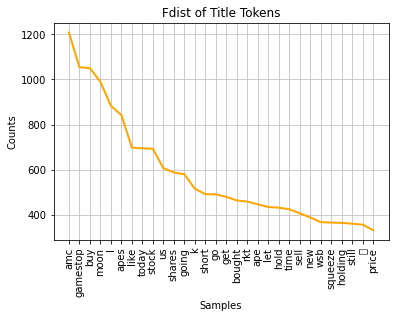

<AxesSubplot:title={'center':'Fdist of Title Tokens'}, xlabel='Samples', ylabel='Counts'>

In [440]:
title_fdist = FreqDist([element for tokenlist in tokenized_lists for element in tokenlist])
print(title_fdist.most_common(20)) #remove gamestop, a lot of 'I LIKE THE STOCK', 'us','k',
title_fdist.plot(30,cumulative=False, color = 'orange', title = "Fdist of Title Tokens") # few stopwords still included

[('buy', 1395), ('ape', 1291), ('amc', 1207), ('go', 1071), ('gamestop', 1063), ('moon', 1015), ('stock', 935), ('i', 883), ('share', 880), ('hold', 824), ('short', 785), ('like', 745), ('today', 732), ('get', 648), ('sell', 621), ('us', 607), ('k', 516), ('time', 465), ('bought', 464), ('rkt', 460)]


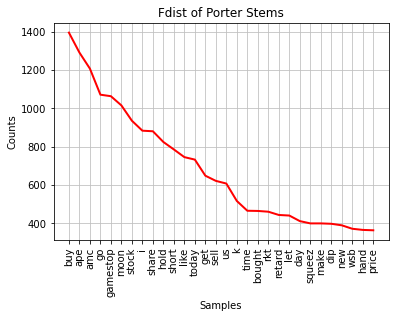

<AxesSubplot:title={'center':'Fdist of Porter Stems'}, xlabel='Samples', ylabel='Counts'>

In [443]:
stems_fdist = FreqDist([element for tokenlist in stems for element in tokenlist])
print(stems_fdist.most_common(20)) #remove gamestop, a lot of 'I LIKE THE STOCK', 'us','k',
stems_fdist.plot(30,cumulative=False, color = 'red', title = "Fdist of Porter Stems") # few stopwords still included

# March SelfText

In [159]:
sub_mar_filtered_body.head()

,title,id,selftext,created
121,GME is about to breakout and I think this is why,mgkwis,"Hello Apes and hedgies, this is my first attem...",1.617153e+09
148,Hertz could become the next GME because of all...,mgij08,Because Hertz's bankruptcy protection status i...,1.617147e+09
208,"GME Megathread for March 30, 2021",mgewny,HOLY MOLY!,1.617136e+09
230,"The $34,000,000 bet against GME! Someone bough...",mgdvw9,Via [optionsentiment](https://optionsentiment....,1.617133e+09
398,National Security risks of hedge fund over-lev...,mfxfuo,"This is brushing up against politics a bit, so...",1.617075e+09


In [182]:
sub_mar_selftext_clean = sub_mar_filtered_body.selftext.apply(selftext_clean)
mar_selftext = text_process_df(sub_mar_selftext_clean, stopgme).reset_index(drop = True)

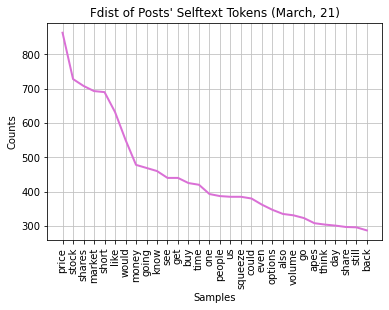

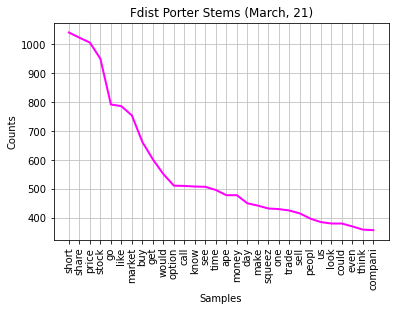

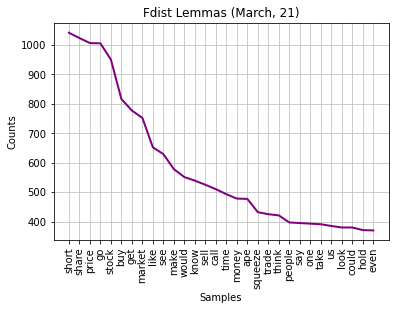

<AxesSubplot:title={'center':'Fdist Lemmas (March, 21)'}, xlabel='Samples', ylabel='Counts'>

In [226]:
mar_selftext_fdist = FreqDist([element for tokenlist in mar_selftext.tokens_list for element in tokenlist])
mar_selftext_fdist.plot(30, color = 'orchid', title = "Fdist of Posts' Selftext Tokens (March, 21)")

mar_selftext_fdiststems = FreqDist([element for tokenlist in mar_selftext.porter_stems for element in tokenlist])
mar_selftext_fdiststems.plot(30, color = 'fuchsia', title = "Fdist Porter Stems (March, 21)")

mar_selftext_lemmas = mar_selftext.tokens_list.apply(lambda x: [lem.lemmatize(element, "v") for element in x])
mar_selftext_fdistlemmas = FreqDist([element for tokenlist in mar_selftext_lemmas for element in tokenlist])
mar_selftext_fdistlemmas.plot(30, cumulative=False, color = 'purple',title='Fdist Lemmas (March, 21)')

In [230]:
sub_jan = pd.read_csv('./data/submissions_jan.csv', index_col = 0)
jan_titletext = text_process_df(sub_jan.title, stopgme)
jan_titletext.head()

,text_cleaned,tokens,tokens_list,porter_stems
0,which exchangesbrokers are still allowing gme ...,"exchangesbrokers,still,allowing,buys","[exchangesbrokers, still, allowing, buys]","[exchangesbrok, still, allow, buy]"
1,remember to set your sell limits for gme,"remember,set,sell,limits","[remember, set, sell, limits]","[rememb, set, sell, limit]"
2,amc even w limited trading we itched upward wi...,"amc,even,w,limited,trading,itched,upward,plent...","[amc, even, w, limited, trading, itched, upwar...","[amc, even, w, limit, trade, itch, upward, ple..."
3,nio gme facts,"nio,facts","[nio, facts]","[nio, fact]"
4,petition to collectively purchase the new york...,"petition,collectively,purchase,new,york,mets,t...","[petition, collectively, purchase, new, york, ...","[petit, collect, purchas, new, york, met, tendi]"


[('buy', 14617), ('amc', 14204), ('gamestop', 7758), ('hold', 7758), ('robinhood', 7370), ('bb', 7202), ('us', 6277), ('I', 5478), ('nok', 5283), ('moon', 5166), ('let', 4923), ('stock', 4682), ('shares', 4522), ('trading', 3880), ('buying', 3681), ('going', 3655), ('get', 3609), ('sell', 3597), ('melvin', 3587), ('short', 3582)]


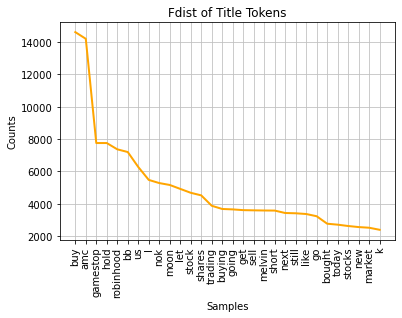

<AxesSubplot:title={'center':'Fdist of Title Tokens'}, xlabel='Samples', ylabel='Counts'>

In [341]:
jan_title_fdist = FreqDist([element for tokenlist in jan_titletext.tokens_list for element in tokenlist])
print(jan_title_fdist.most_common(20)) #remove gamestop, a lot of 'I LIKE THE STOCK', 'us','k',
jan_title_fdist.plot(30,cumulative=False, color = 'orange', title = "Fdist of Title Tokens") # few stopwords still included

[('buy', 18965), ('amc', 14209), ('hold', 10235), ('gamestop', 7781), ('robinhood', 7503), ('stock', 7317), ('bb', 7209), ('go', 6888), ('us', 6277), ('share', 6270), ('trade', 5835), ('short', 5720), ('i', 5483), ('sell', 5320), ('nok', 5286), ('moon', 5252), ('let', 5217), ('fuck', 4735), ('get', 4574), ('melvin', 3643)]


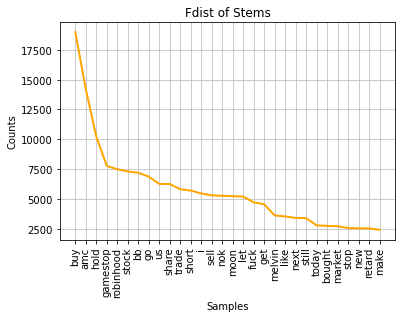

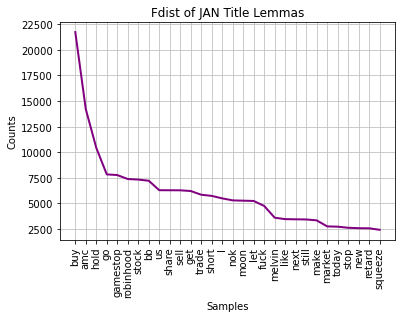

<AxesSubplot:title={'center':'Fdist of JAN Title Lemmas'}, xlabel='Samples', ylabel='Counts'>

In [504]:
jan_title_fdiststems = FreqDist([element for tokenlist in jan_titletext.porter_stems for element in tokenlist])
print(jan_title_fdiststems.most_common(20)) #remove gamestop, a lot of 'I LIKE THE STOCK', 'us','k',
jan_title_fdiststems.plot(30,cumulative=False, color = 'orange', title = "Fdist of Stems") # few stopwords still included

lemmas = jan_titletext.tokens_list.apply(lambda x: [lem.lemmatize(element,"v") for element in x])
jan_fdistlemmas = FreqDist([element for tokenlist in lemmas for element in tokenlist])
jan_fdistlemmas.plot(30, cumulative=False, color = 'purple',title='Fdist of JAN Title Lemmas')

# January Selftext

In [251]:
cond = (sub_jan.selftext.notna()) & (sub_jan.selftext !='[removed]') & (sub_jan.selftext !='[deleted]')
sub_jan_filtered = sub_jan[cond].reset_index(drop = True)
print(f'There were {sub_jan.shape[0]-sub_jan_filtered.shape[0]} posts with empty, *removed* or *deleted* text body \nLeft with {sub_jan_filtered.shape[0]} posts')
sub_jan_filtered.head(5)

There were 89783 posts with empty, *removed* or *deleted* text body 
Left with 6962 posts


,title,id,selftext,created
0,How GME and Citadel could be the catalyst for ...,l8zd0i,Pretty sure everyone and their mom at this poi...,1.612080e+09
1,Stop Overlooking Kodak,l8z8yo,"Listen up retards, I know you have a short att...",1.612080e+09
2,I want to buy GME in Australia please help me ...,l8z3xa,As the title says. I want to do my part and st...,1.612079e+09
3,"TD - ""Call our human brokers"" (WTF)",l8yum7,[TD](https://www.tdameritrade.com/td-ameritrad...,1.612078e+09
4,IGNORE the DISTRACTIONS ! REMEMBER the MECHANI...,l8yfu7,I don't know shit and I'm not a learned Charte...,1.612077e+09


In [253]:
jan_selftext = text_process_df(sub_jan_filtered.selftext.apply(selftext_clean), stopgme)
jan_selftext.head(5)

,text_cleaned,tokens,tokens_list,porter_stems
0,pretty sure everyone and their mom at this poi...,"pretty,sure,everyone,mom,point,know,whole,shor...","[pretty, sure, everyone, mom, point, know, who...","[pretti, sure, everyon, mom, point, know, whol..."
1,listen up retards i know you have a short atte...,"listen,retards,know,short,attention,span,make,...","[listen, retards, know, short, attention, span...","[listen, retard, know, short, attent, span, ma..."
2,as the title says i want to do my part and sti...,"title,says,want,part,stick,billionaire,hfs,fuc...","[title, says, want, part, stick, billionaire, ...","[titl, say, want, part, stick, billionair, hf,..."
3,td is forcing you to call their human brokers...,"td,forcing,call,human,brokers,route,option,ord...","[td, forcing, call, human, brokers, route, opt...","[td, forc, call, human, broker, rout, option, ..."
4,i do not know shit and i am not a learned char...,"know,shit,learned,chartered,financial,analyst,...","[know, shit, learned, chartered, financial, an...","[know, shit, learn, charter, financi, analyst,..."


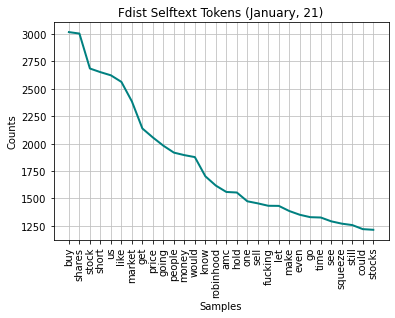

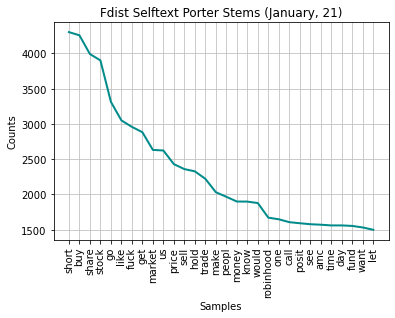

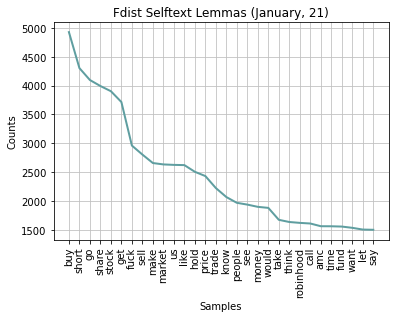

<AxesSubplot:title={'center':'Fdist Selftext Lemmas (January, 21)'}, xlabel='Samples', ylabel='Counts'>

In [258]:
jan_selftext_fdist = FreqDist([element for tokenlist in jan_selftext.tokens_list for element in tokenlist])
jan_selftext_fdist.plot(30, title = "Fdist Selftext Tokens (January, 21)", color = 'teal')

jan_selftext_fdiststems = FreqDist([element for tokenlist in jan_selftext.porter_stems for element in tokenlist])
jan_selftext_fdiststems.plot(30, title = "Fdist Selftext Porter Stems (January, 21)", color = 'darkcyan')

jan_selftext_lemmas = jan_selftext.tokens_list.apply(lambda x: [lem.lemmatize(element,"v") for element in x])
jan_selftext_fdistlemmas = FreqDist([element for tokenlist in jan_selftext_lemmas for element in tokenlist])
jan_selftext_fdistlemmas.plot(30, title = "Fdist Selftext Lemmas (January, 21)", color = 'cadetblue')

---
# February Titles

[('amc', 10170), ('buy', 7343), ('hold', 5333), ('gamestop', 4845), ('I', 4036), ('shares', 3501), ('moon', 3329), ('holding', 3246), ('stock', 3150), ('us', 2979), ('bought', 2963), ('short', 2759), ('like', 2702), ('still', 2514), ('buying', 2500), ('sell', 2231), ('let', 2170), ('today', 2150), ('going', 2089), ('robinhood', 2074)]


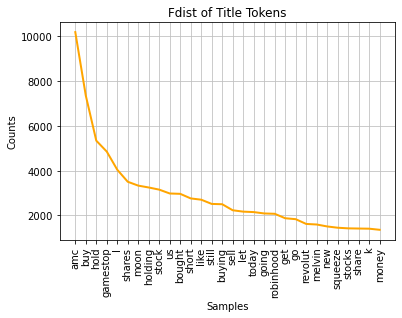

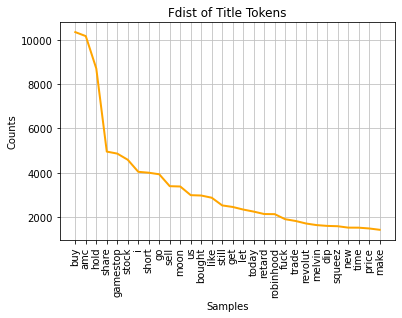

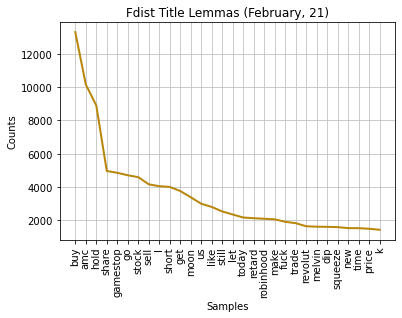

<AxesSubplot:title={'center':'Fdist Title Lemmas (February, 21)'}, xlabel='Samples', ylabel='Counts'>

In [262]:
sub_feb = pd.read_csv('./data/submissions_feb.csv', index_col = 0)
feb_titletext = text_process_df(sub_feb.title, stopgme)

feb_title_fdist = FreqDist([element for tokenlist in feb_titletext.tokens_list for element in tokenlist])
print(feb_title_fdist.most_common(20)) #remove gamestop, a lot of 'I LIKE THE STOCK', 'us','k',
feb_title_fdist.plot(30,cumulative=False, color = 'orange', title = "Fdist of Title Tokens") # few stopwords still included

feb_title_fdiststems = FreqDist([element for tokenlist in feb_titletext.porter_stems for element in tokenlist])
feb_title_fdiststems.plot(30,cumulative=False, color = 'orange', title = "Fdist of Title Tokens") # few stopwords still included

feb_title_lemmas = feb_titletext.tokens_list.apply(lambda x: [lem.lemmatize(element,'v') for element in x])
feb_title_fdistlemmas = FreqDist([element for lemmalist in feb_title_lemmas for element in lemmalist])
feb_title_fdistlemmas.plot(30, cumulative = False, title = "Fdist Title Lemmas (February, 21)", color = 'darkgoldenrod')

# February Selftext

In [264]:
cond = (sub_feb.selftext.notna()) & (sub_feb.selftext !='[removed]') & (sub_feb.selftext !='[deleted]')
sub_feb_filtered = sub_feb[cond].reset_index(drop = True)
print(f'There were {sub_feb.shape[0]-sub_feb_filtered.shape[0]} posts with empty, *removed* or *deleted* text body \nLeft with {sub_feb_filtered.shape[0]} posts')
sub_feb_filtered.head(5)

There were 57016 posts with empty, *removed* or *deleted* text body 
Left with 2813 posts


,title,id,selftext,created
0,"When GME, AMC go to the moon. DD on where to i...",ltzrbg,"I have been following the **GME, AMC** short s...",1.614496e+09
1,Using Covered Calls to Buy Volatile Stocks lik...,ltzb4d,"# Typically, covered calls provide a laughable...",1.614495e+09
2,AMC/GME STONKS: YOU MUST HAVE A CASH ACCOUNT!!,ltyubg,"""What may infuriate WSB users, is the fact tha...",1.614493e+09
3,AMC/GMC YOU MUST MOVE TO A CASH ACCOUNT!!!,ltxv73,**(THIS SHOULD SAY AMC/GME)** ...,1.614490e+09
4,(GME DD) Why the Volkswagen Comparison is much...,ltudu7,Hey folks!\nI’m not exactly one to do too much...,1.614480e+09


In [282]:
feb_selftext = text_process_df(sub_feb_filtered.selftext.apply(selftext_clean), stopgme)
feb_selftext.head(5)

,text_cleaned,tokens,tokens_list,porter_stems
0,i have been following the gme amc short squeez...,"following,amc,short,squeeze,gamma,squeeze,clos...","[following, amc, short, squeeze, gamma, squeez...","[follow, amc, short, squeez, gamma, squeez, cl..."
1,typically covered calls provide a laughable pr...,"typically,covered,calls,provide,laughable,prem...","[typically, covered, calls, provide, laughable...","[typic, cover, call, provid, laughabl, premium..."
2,what may infuriate wsb users is the fact that ...,"may,infuriate,wsb,users,fact,shares,made,avail...","[may, infuriate, wsb, users, fact, shares, mad...","[may, infuri, wsb, user, fact, share, made, av..."
3,this should say amcgme ...,"say,amcgme,wsb,community,hoards,gamestop,share...","[say, amcgme, wsb, community, hoards, gamestop...","[say, amcgm, wsb, commun, hoard, gamestop, sha..."
4,hey folksi’m not exactly one to do too much di...,"hey,folksi,’,exactly,one,much,digging,numbers,...","[hey, folksi, ’, exactly, one, much, digging, ...","[hey, folksi, ’, exactli, one, much, dig, numb..."


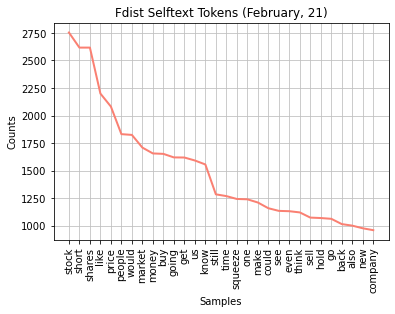

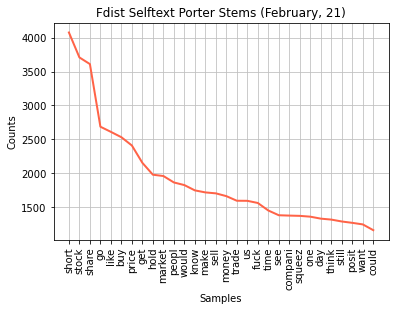

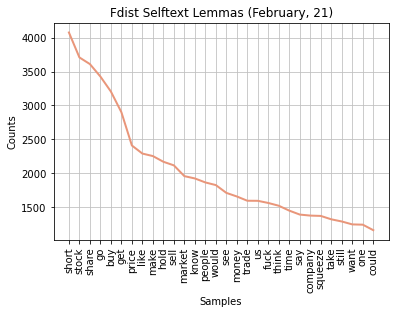

<AxesSubplot:title={'center':'Fdist Selftext Lemmas (February, 21)'}, xlabel='Samples', ylabel='Counts'>

In [283]:
feb_selftext_fdist = FreqDist([element for tokenlist in feb_selftext.tokens_list for element in tokenlist])
feb_selftext_fdist.plot(30, title = "Fdist Selftext Tokens (February, 21)", color = 'salmon')

feb_selftext_fdiststems = FreqDist([element for tokenlist in feb_selftext.porter_stems for element in tokenlist])
feb_selftext_fdiststems.plot(30, title = "Fdist Selftext Porter Stems (February, 21)", color = 'tomato')

feb_selftext_lemmas = feb_selftext.tokens_list.apply(lambda x: [lem.lemmatize(element,"v") for element in x])
feb_selftext_fdistlemmas = FreqDist([element for tokenlist in feb_selftext_lemmas for element in tokenlist])
feb_selftext_fdistlemmas.plot(30, title = "Fdist Selftext Lemmas (February, 21)", color = 'darksalmon')

<function matplotlib.pyplot.show(close=None, block=None)>

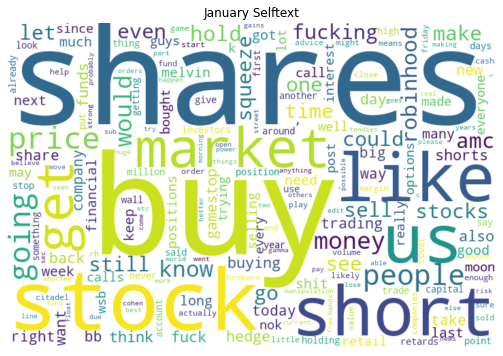

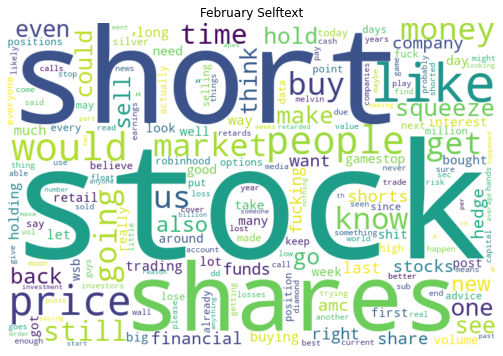

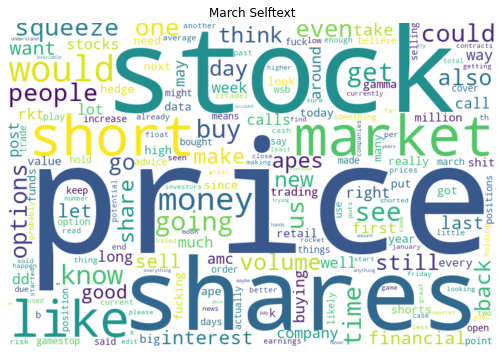

In [338]:
plt.figure(figsize=[12,6])
plt.imshow(WordCloud(background_color="white", stopwords = stopgme, width = 720, height = 480).generate_from_frequencies(jan_selftext_fdist),interpolation="bilinear")
plt.axis('off')
plt.title("January Selftext")
plt.show

plt.figure(figsize = [12,6])
plt.imshow(WordCloud(background_color="white", stopwords = stopgme, width = 720, height = 480).generate_from_frequencies(feb_selftext_fdist),interpolation="bilinear")
plt.axis('off')
plt.title("February Selftext")
plt.show

plt.figure(figsize = [12,6])
plt.imshow(WordCloud(background_color="white", stopwords = stopgme, width = 720, height = 480).generate_from_frequencies(mar_selftext_fdist),interpolation="bilinear")
plt.axis('off')
plt.title("March Selftext")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

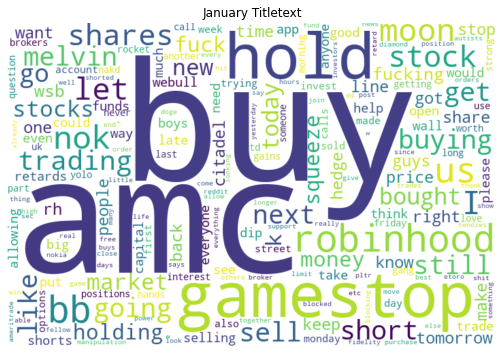

In [343]:
plt.figure(figsize=[12,6])
plt.imshow(WordCloud(background_color="white", stopwords = stopgme, width = 720, height = 480).generate_from_frequencies(jan_title_fdist),interpolation="bilinear")
plt.axis('off')
plt.title("January Titletext")
plt.show

----
----
----
# CLASSES

In [1]:
%load_ext autoreload
%autoreload 1
%aimport sentiment
from sentiment import *

In [4]:
sub_apr = TextAnalysis('./data/submissions_apr.csv')
#f'Removed {sub_apr.raw_data.shape[0]-sub_apr.processed_data.shape[0]} duplicated rows'
sub_apr.process_data('title', stopgme, emoji = True)
sub_apr.get_WordFrequency()
sub_apr.get_PorterFrequency()
sub_apr.getNgrams(n = 2)

[(('rocket', 'rocket'), 3856),
 (('let', 'us'), 828),
 (('short', 'squeeze'), 461),
 (('gem_stone', 'raising_hands'), 443),
 (('gorilla', 'gorilla'), 435)]

In [5]:
sub_apr.processed_data.head(5)

,text_cleaned,tokens,tokens_list,porter_stems,bigrams_list
0,potential bagger willow biosciences wllwtsx ...,"potential,bagger,willow,biosciences,wllwtsx,ca...","[potential, bagger, willow, biosciences, wllwt...","[potenti, bagger, willow, bioscienc, wllwtsx, ...","[(potential, bagger), (bagger, willow), (willo..."
1,arrival post deleted not sure why posting agai...,"arrival,post,deleted,sure,posting,small,public...","[arrival, post, deleted, sure, posting, small,...","[arriv, post, delet, sure, post, small, public...","[(arrival, post), (post, deleted), (deleted, s..."
2,yolod k into mnmd while on shrooms,"yolod,k,mnmd,shrooms","[yolod, k, mnmd, shrooms]","[yolod, k, mnmd, shroom]","[(yolod, k), (k, mnmd), (mnmd, shrooms)]"
3,i have never heard this before listen to the l...,"never,heard,listen,last,minute,nothing,else,sq...","[never, heard, listen, last, minute, nothing, ...","[never, heard, listen, last, minut, noth, els,...","[(never, heard), (heard, listen), (listen, las..."
4,community banking tendies,"community,banking,tendies","[community, banking, tendies]","[commun, bank, tendi]","[(community, banking), (banking, tendies)]"


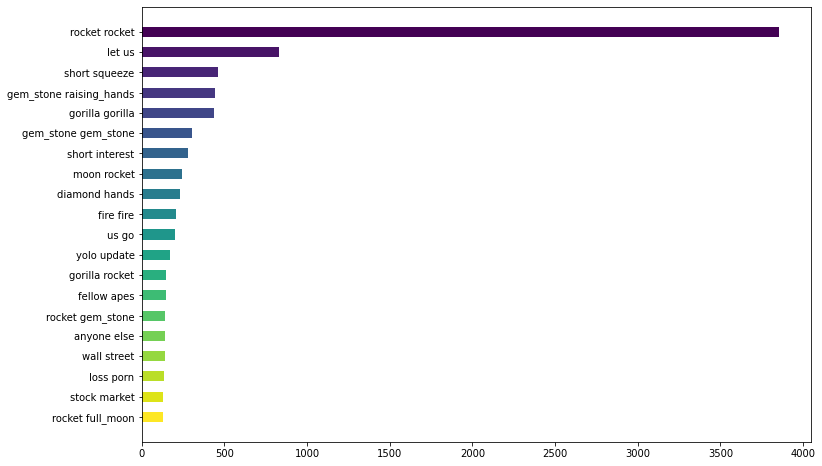

In [6]:
fig, ax = plt.subplots(figsize = (12,8))
data = FreqDist(sub_apr.bigrams).most_common(20)

cmap = [plt.get_cmap('viridis')(i) for i in np.linspace(1,0, len(data))]

for item, col in zip(data[::-1], cmap):
    word, count = item
    word = " ".join(word)
    ax.barh(y=word, width = count, height = .5, color = col)
plt.show()

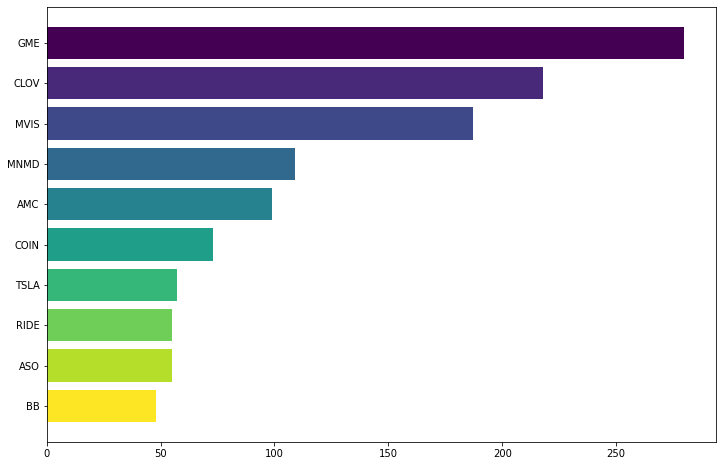

In [7]:
sub_apr.get_TickerMentions(plot = True)

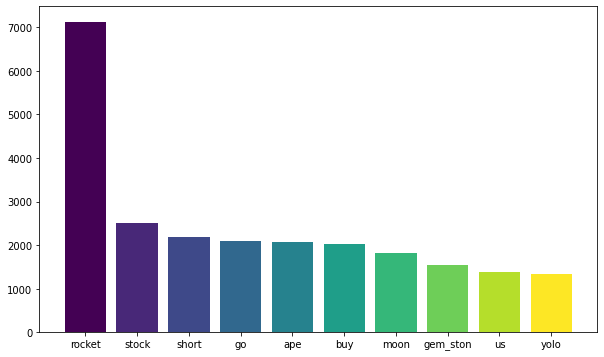

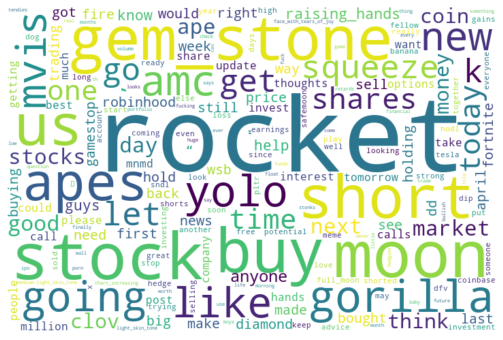

In [8]:
# sub_apr.freq_plot(top = 15)
fig, ax = plt.subplots(figsize = (10,6))
data = sub_apr.word_freq.most_common(10)
cmap = [plt.get_cmap('viridis')(i) for i in np.linspace(0,1, len(data))]

for item, col in zip(data, cmap):
    word, count = item
    ax.bar(x = word, height = count, width = .8, color = col)

ax.set_xlabel('Word')
ax.set_ylabel('Frequency')

plt.close()
fig, ax = plt.subplots(figsize = (10,6))
data = sub_apr.porter_freq.most_common(15)

for item, col in zip(data, cmap):
    word, count = item
    ax.bar(x = word, height = count, width = .8, color = col)


sub_apr.wordcloud(stopgme)

plt.show()

---
---

## Named Entity Recognition

In [10]:
org = sub_apr.chunking_NER('title','ORGANIZATION')

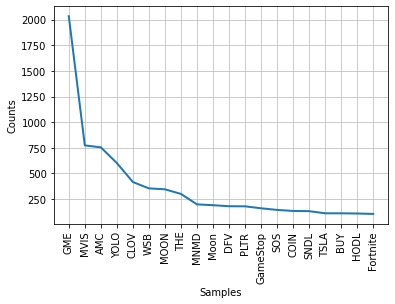

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [13]:
org.plot(20)

In [8]:
sub_apr.getNgrams(n=3)

[(('rocket', 'rocket', 'rocket'), 2321),
 (('gorilla', 'gorilla', 'gorilla'), 255),
 (('let', 'us', 'go'), 195),
 (('gem_stone', 'gem_stone', 'gem_stone'), 154),
 (('moon', 'rocket', 'rocket'), 140)]

## Collocation

In [9]:
sub_apr.get_Collocations(freq_limit = 3, method = 'likelihood')

('rocket', 'rocket')
('let', 'us')
('gem_stone', 'raising_hands')
('short', 'squeeze')
('gorilla', 'gorilla')
('diamond', 'hands')
('short', 'interest')
('wall', 'street')
('fire', 'fire')
('loss', 'porn')


In [10]:
FreqDist(sub_apr.bigrams).most_common(10)

[(('rocket', 'rocket'), 3856),
 (('let', 'us'), 828),
 (('short', 'squeeze'), 461),
 (('gem_stone', 'raising_hands'), 443),
 (('gorilla', 'gorilla'), 435),
 (('gem_stone', 'gem_stone'), 307),
 (('short', 'interest'), 279),
 (('moon', 'rocket'), 247),
 (('diamond', 'hands'), 232),
 (('fire', 'fire'), 207)]

In [11]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(sub_apr.processed_data.tokens_list)
len(finder.score_ngrams(bigram_measures.raw_freq))
finder.apply_word_filter(lambda w: w in ('rocket','rocket'))
finder.apply_freq_filter(3)
len(finder.score_ngrams(bigram_measures.raw_freq))
scored = finder.score_ngrams(bigram_measures.raw_freq)
pd.DataFrame(scored, columns = ['bigram', 'freq'])['freq'].diff().max()
pd.DataFrame(scored, columns = ['bigram', 'freq']).set_index('bigram').iloc[:5]

,freq
bigram,
"(let, us)",0.003661
"(short, squeeze)",0.002038
"(gem_stone, raising_hands)",0.001959
"(gorilla, gorilla)",0.001923
"(gem_stone, gem_stone)",0.001358


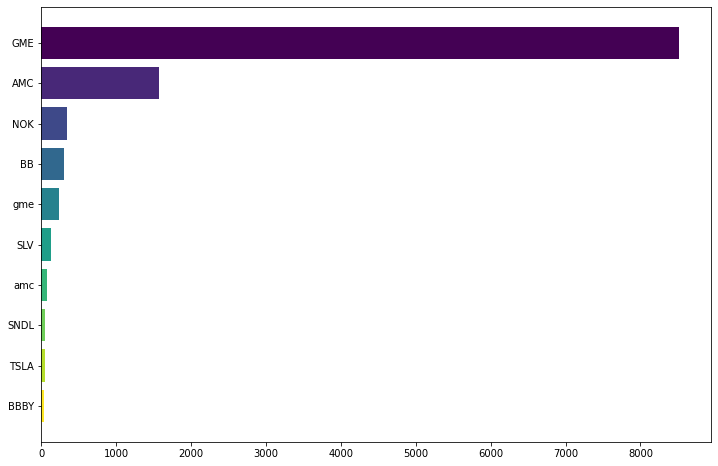

In [12]:
data = TextAnalysis('./data/submissions_feb.csv')
#f'Removed {sub_apr.raw_data.shape[0]-sub_apr.processed_data.shape[0]} duplicated rows'
data.process_data('title', stopgme, emoji = True)
data.get_WordFrequency()
data.get_PorterFrequency()
data.getNgrams(n = 2)
data.get_TickerMentions(plot = True)